# Reactive Jupyter Notebook with reaktiv

This notebook demonstrates how to create reactive cells and visualizations using `reaktiv` library in a standard Jupyter notebook.

## Getting Started

First, let's install and import the required libraries:

In [33]:
# !pip install reaktiv numpy matplotlib pandas seaborn

from reaktiv import Signal, Computed, Effect
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Set matplotlib to inline mode
%matplotlib inline

## Example 1: Simple Reactive Plot

Let's create a simple reactive plot that updates automatically when parameters change:

In [34]:
# Create reactive parameters
x_min = Signal(-10)
x_max = Signal(10)
num_points = Signal(100)
function_type = Signal("sin")  # "sin" or "cos"
amplitude = Signal(1.0)

In [35]:
# Create a computed signal for the data
def compute_data():
    x = np.linspace(x_min(), x_max(), num_points())
    
    if function_type() == "sin":
        y = amplitude() * np.sin(x)
    else:
        y = amplitude() * np.cos(x)
    
    return x, y

plot_data = Computed(compute_data)

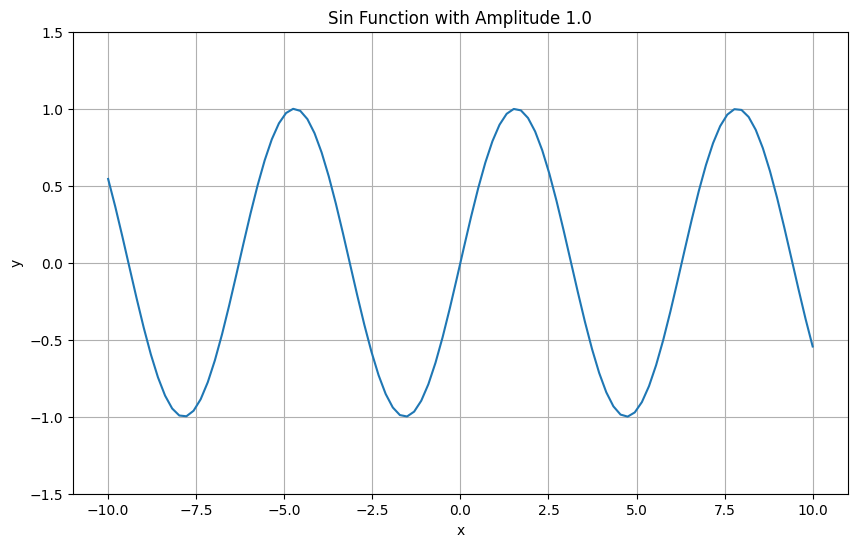

Function: sin
Range: [-10, 10]
Number of points: 100


In [36]:
# Create a reactive plotting function
def plot_reactive_chart():
    clear_output(wait=True)
    x, y = plot_data()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y)
    ax.set_title(f"{function_type().capitalize()} Function with Amplitude {amplitude()}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.set_ylim(-1.5 * amplitude(), 1.5 * amplitude())
    plt.show()
    
    # Print some statistics
    print(f"Function: {function_type()}")
    print(f"Range: [{x_min()}, {x_max()}]")
    print(f"Number of points: {num_points()}")

# Create an effect that will automatically re-run when dependencies change
chart_effect = Effect(plot_reactive_chart)

Now our chart is displayed above. Let's update some parameters and see the chart update automatically:

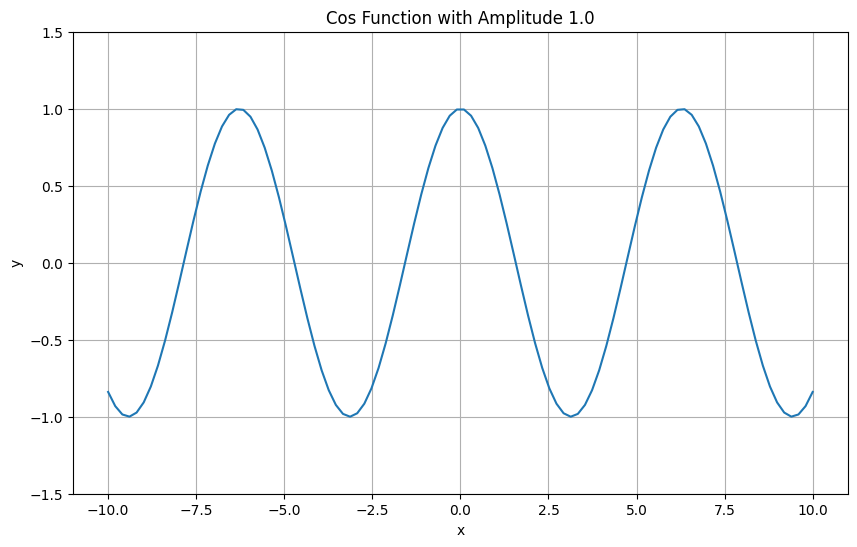

Function: cos
Range: [-10, 10]
Number of points: 100


In [37]:
# Change the function type - chart updates automatically!
function_type.set("cos")

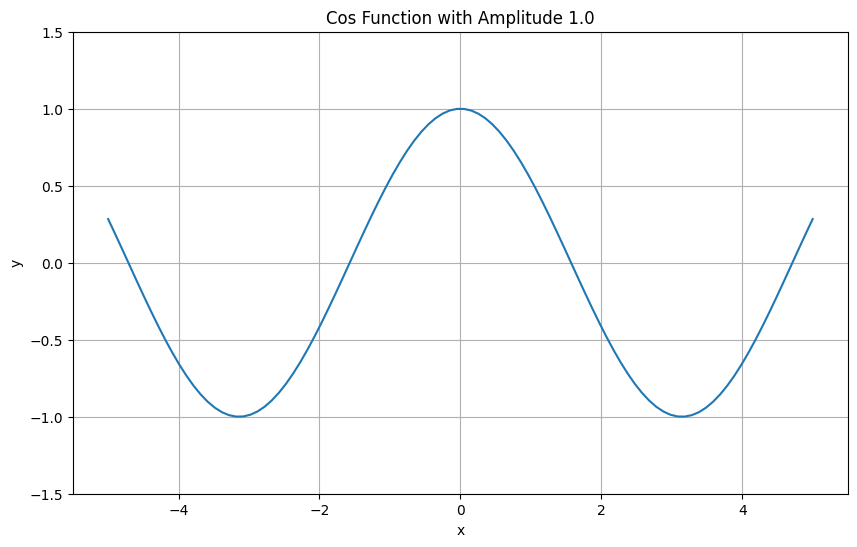

Function: cos
Range: [-5, 5]
Number of points: 100


In [38]:
# Change the x range - chart updates automatically!
x_min.set(-5)
x_max.set(5)

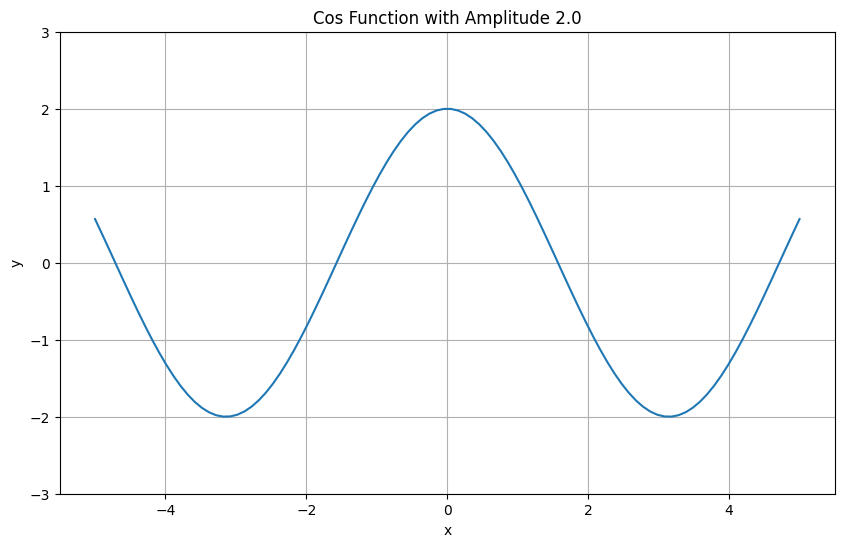

Function: cos
Range: [-5, 5]
Number of points: 100


In [39]:
# Change the amplitude - chart updates automatically!
amplitude.set(2.0)

## Example 2: Interactive Controls with ipywidgets

Let's create interactive controls using ipywidgets that connect to our reactive signals:

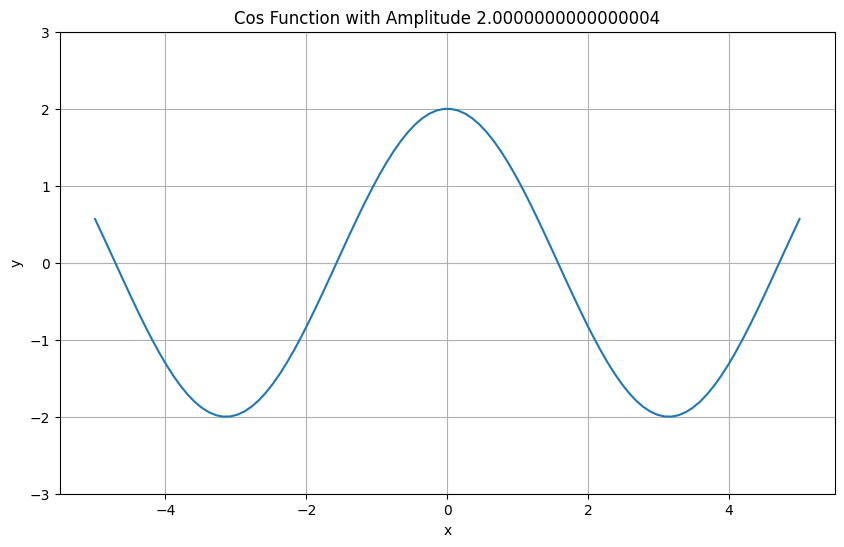

In [ ]:
import ipywidgets as widgets

# Create widgets
function_dropdown = widgets.Dropdown(
    options=[('Sine', 'sin'), ('Cosine', 'cos')],
    value=function_type(),
    description='Function:'
)

amplitude_slider = widgets.FloatSlider(
    value=amplitude(),
    min=0.1,
    max=5.0,
    step=0.1,
    description='Amplitude:'
)

range_slider = widgets.FloatRangeSlider(
    value=[x_min(), x_max()],
    min=-20.0,
    max=20.0,
    step=1.0,
    description='X Range:'
)

points_slider = widgets.IntSlider(
    value=num_points(),
    min=10,
    max=500,
    step=10,
    description='Points:'
)

In [41]:
# Define update handlers
def on_function_change(change):
    function_type.set(change['new'])
    
def on_amplitude_change(change):
    amplitude.set(change['new'])
    
def on_range_change(change):
    x_min.set(change['new'][0])
    x_max.set(change['new'][1])
    
def on_points_change(change):
    num_points.set(change['new'])

# Register handlers
function_dropdown.observe(on_function_change, names='value')
amplitude_slider.observe(on_amplitude_change, names='value')
range_slider.observe(on_range_change, names='value')
points_slider.observe(on_points_change, names='value')

In [42]:
# Display the control panel
control_panel = widgets.VBox([
    widgets.HBox([function_dropdown, amplitude_slider]),
    widgets.HBox([range_slider, points_slider])
])

display(control_panel)

## Example 3: Reactive Data Analysis

Let's create a reactive data analysis example with a real dataset:

In [43]:
import pandas as pd
import seaborn as sns

# Load the Iris dataset
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [44]:
# Create reactive parameters for data exploration
x_feature = Signal("sepal_length")
y_feature = Signal("sepal_width")
species_filter = Signal("all")  # "all", "setosa", "versicolor", or "virginica"
plot_type = Signal("scatter")   # "scatter", "boxplot", or "histogram"

# Create computed signal for filtered data
def get_filtered_data():
    if species_filter() == "all":
        return iris
    else:
        return iris[iris.species == species_filter()]

filtered_data = Computed(get_filtered_data)

In [45]:
# Create an output widget to contain our visualization
from ipywidgets import Output
output_widget = Output()

In [46]:
# Create reactive visualization that updates only inside the output widget
def plot_data_viz():
    # Clear only the output widget content, not the whole cell
    output_widget.clear_output(wait=True)
    
    # Use the output widget context manager to restrict display to the widget
    with output_widget:
        data = filtered_data()
        x = x_feature()
        y = y_feature()
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if plot_type() == "scatter":
            sns.scatterplot(data=data, x=x, y=y, hue="species", ax=ax)
            plt.title(f"Scatter Plot: {x} vs {y}")
        elif plot_type() == "boxplot":
            sns.boxplot(data=data, y=x, x="species", ax=ax)
            plt.title(f"Box Plot of {x} by Species")
        else:  # histogram
            sns.histplot(data=data, x=x, hue="species", kde=True, ax=ax)
            plt.title(f"Histogram of {x}")
        
        plt.tight_layout()
        plt.show()
        
        # Display summary statistics
        print(f"Dataset: Iris ({len(data)} records)")
        if species_filter() != "all":
            print(f"Filtered to species: {species_filter()}")
        
        print(f"\nSummary Statistics for {x}:")
        display(data[x].describe())

# Create visualization effect
viz_effect = Effect(plot_data_viz)

In [47]:
# Create widgets for data exploration
feature_options = list(iris.select_dtypes(include='number').columns)
species_options = ["all"] + list(iris.species.unique())
plot_options = ["scatter", "boxplot", "histogram"]

x_dropdown = widgets.Dropdown(
    options=feature_options,
    value=x_feature(),
    description='X Feature:'
)

y_dropdown = widgets.Dropdown(
    options=feature_options,
    value=y_feature(),
    description='Y Feature:'
)

species_dropdown = widgets.Dropdown(
    options=species_options,
    value=species_filter(),
    description='Species:'
)

plot_dropdown = widgets.Dropdown(
    options=plot_options,
    value=plot_type(),
    description='Plot Type:'
)

# Link widgets to signals
x_dropdown.observe(lambda change: x_feature.set(change['new']), names='value')
y_dropdown.observe(lambda change: y_feature.set(change['new']), names='value')
species_dropdown.observe(lambda change: species_filter.set(change['new']), names='value')
plot_dropdown.observe(lambda change: plot_type.set(change['new']), names='value')

In [48]:
# Display controls first, followed by the output widget
controls = widgets.VBox([
    widgets.HBox([x_dropdown, y_dropdown]),
    widgets.HBox([species_dropdown, plot_dropdown])
])

# Create a layout with controls above, visualization below
display(widgets.VBox([
    controls,  # Control widgets stay fixed at the top
    output_widget  # Visualization updates within this widget
]))

## Conclusion

This notebook demonstrates how to use `reaktiv` to create reactive notebooks with automatic updates. The key benefits are:

1. Automatic dependency tracking between data elements
2. Efficient updates - only what needs to be recalculated is updated
3. Clean integration with standard Jupyter widgets and visualization libraries
4. Improved user experience for data exploration

For more complex examples and documentation, visit the [reaktiv GitHub repository](https://github.com/buiapp/reaktiv).